In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from IPython.display import display
import datetime
import numpy as np
import shap
from catboost import CatBoostClassifier

## Context

    It is important context to note that we have structured this problem as a time-sensitive forecasting problem, forecasting whether or not a given client will convert into a paying customer within the next week. It is also worth noting that for the sake of limiting the time invested here, we will be using catboost, a gradient-boosted tree algorithm that automatically handles categorical variables.

## Data IO, Exploration and Joining

    We load each of the datasets into memory and generate a histogram for each potential feature. A few things that stand out are that MRR is at times negative (we assume this is a refund, but won't be using it within the model because it is not generalizable anyways) and that the majority of the behavioral metrics are gamma distributed (this would be quite important if we were taking a linear approach to the problem).

In [2]:
customers = pd.read_csv('customers.csv')

In [3]:
customers = customers.set_index('id')

In [4]:
customers.CLOSEDATE = pd.to_datetime(customers.CLOSEDATE)
customers.EMPLOYEE_RANGE = customers.EMPLOYEE_RANGE.replace('1', '1 to 1')
customers.EMPLOYEE_RANGE = customers.EMPLOYEE_RANGE = customers.EMPLOYEE_RANGE.str./
split(' ').str[0].str.replace(',', '').astype(float)
customers.INDUSTRY = customers.INDUSTRY.astype('category')

<Axes: title={'center': 'CLOSEDATE'}, xlabel='CLOSEDATE', ylabel='Count'>

<Axes: title={'center': 'MRR'}, xlabel='MRR', ylabel='Count'>

<Axes: title={'center': 'ALEXA_RANK'}, xlabel='ALEXA_RANK', ylabel='Count'>

<Axes: title={'center': 'EMPLOYEE_RANGE'}, xlabel='EMPLOYEE_RANGE', ylabel='Count'>

<Axes: title={'center': 'INDUSTRY'}, xlabel='Count', ylabel='INDUSTRY'>

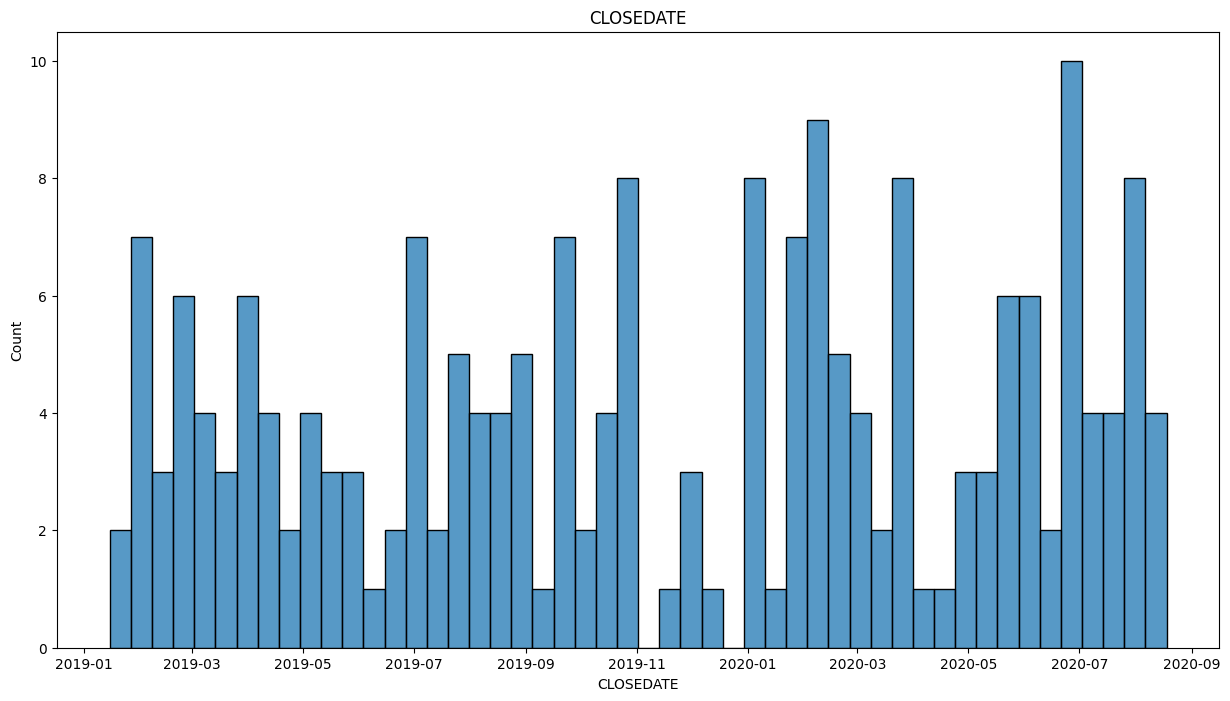

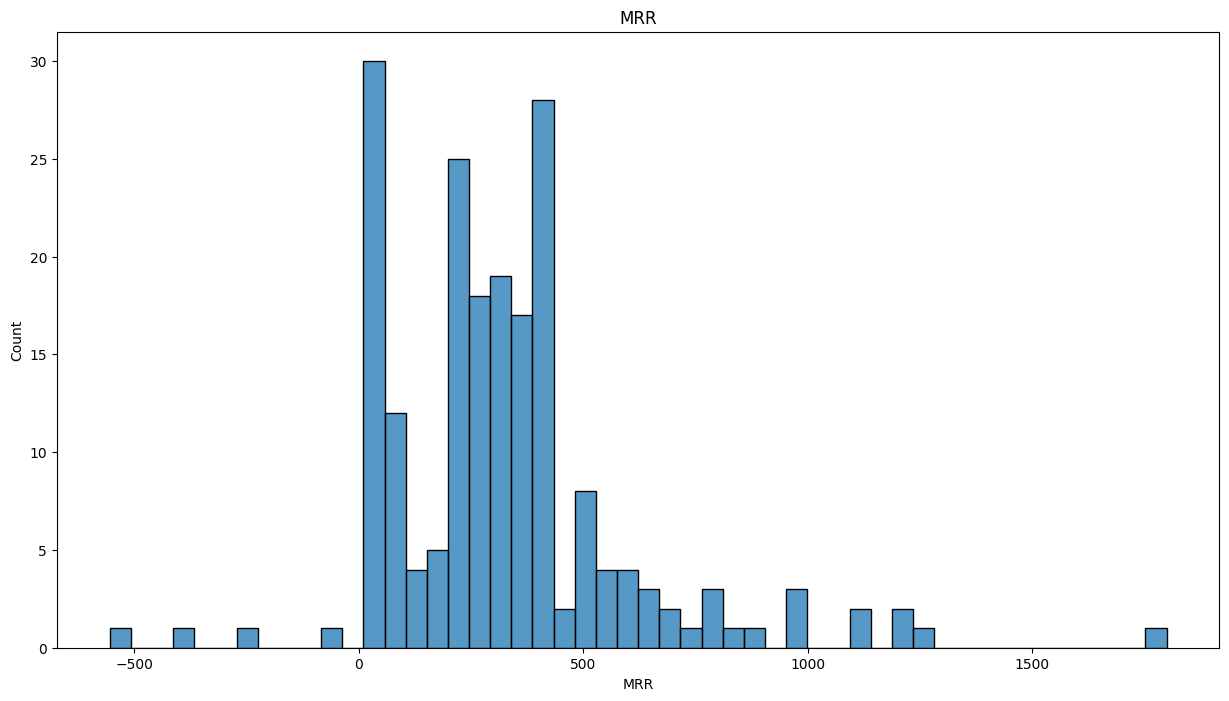

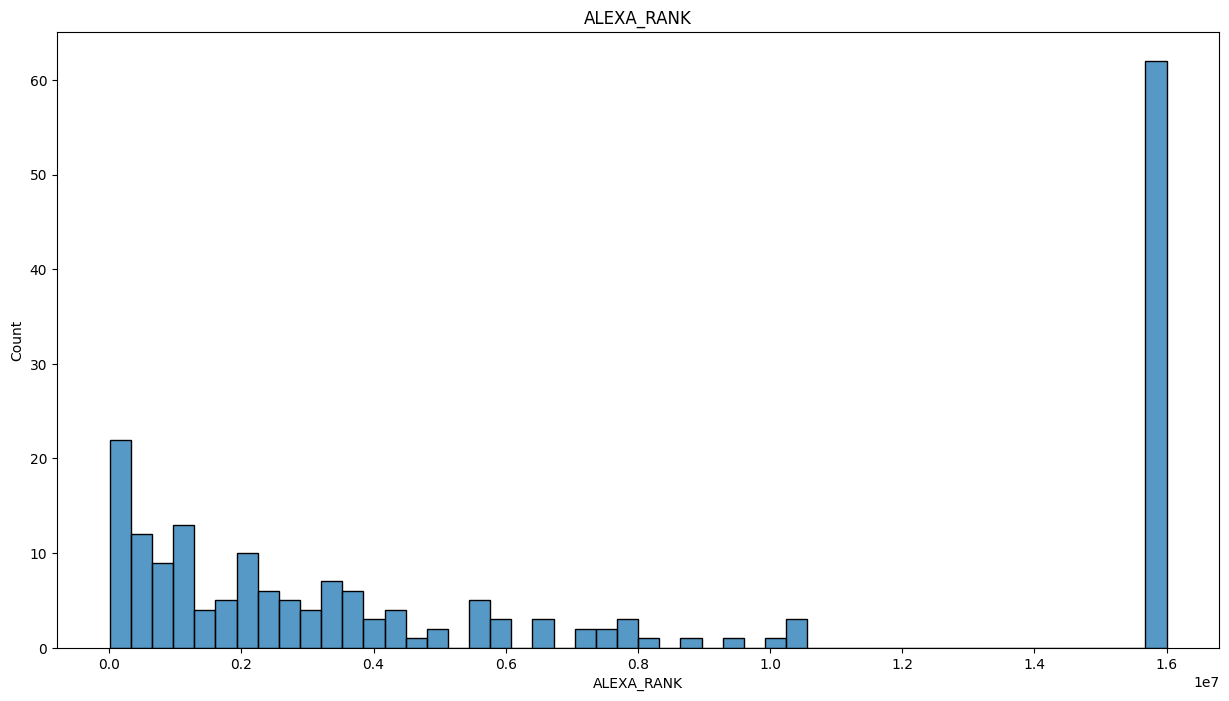

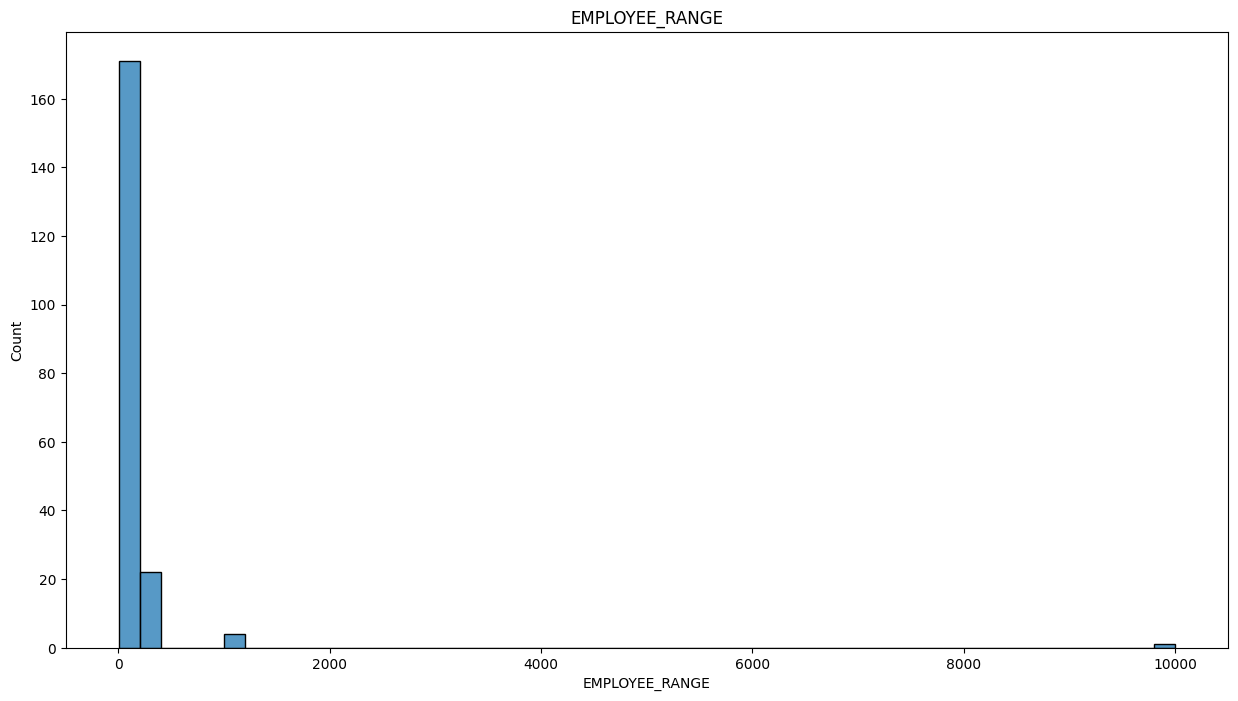

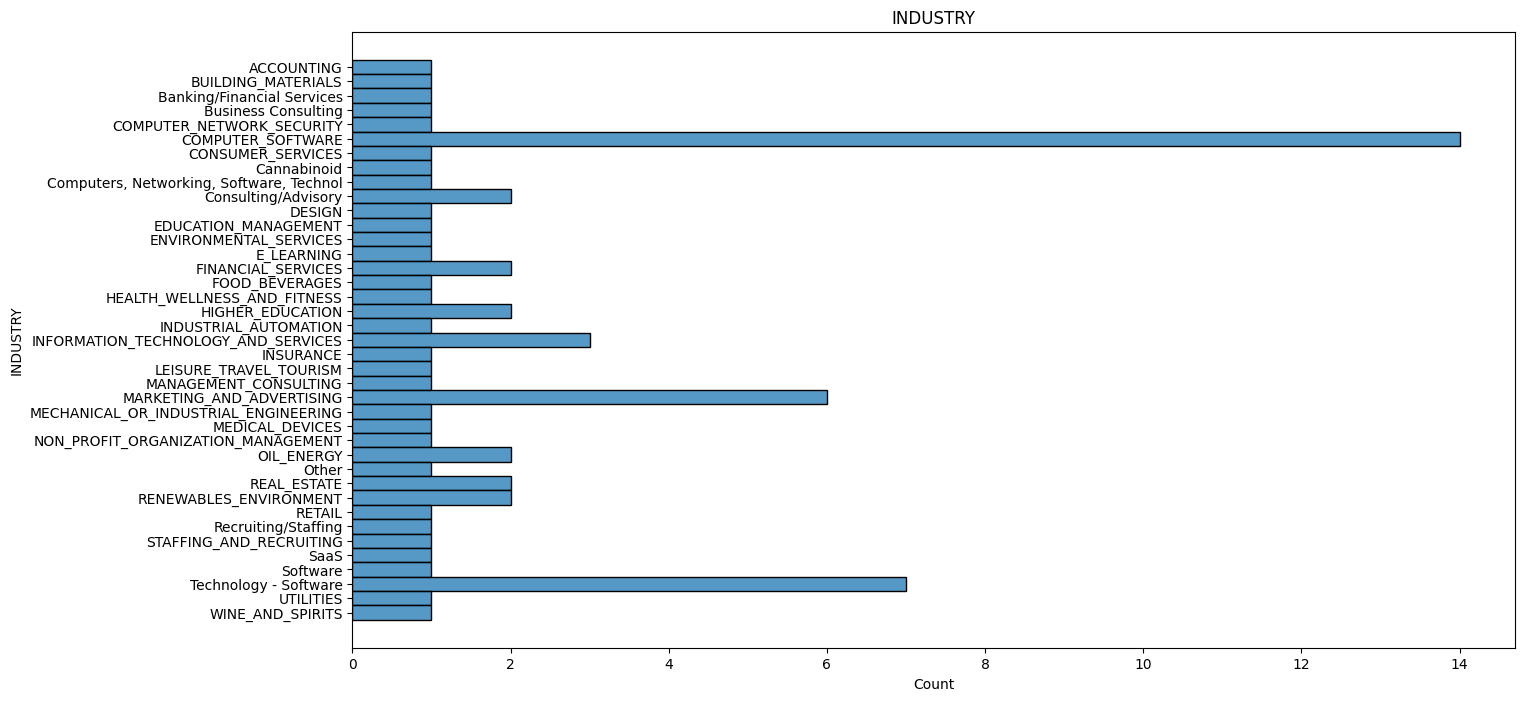

In [5]:
for c in customers.columns:
    plt.figure(figsize=(15,8))
    if c == 'INDUSTRY':
        g = seaborn.histplot(y=customers[c])
    elif c == 'EMPLOYEE_RANGE':
        g = seaborn.histplot(x=customers[c] + 1, bins=50)
    else:
        g = seaborn.histplot(x=customers[c], bins=50)
    g.set_title(c)
    display(g)

In [6]:
noncustomers = pd.read_csv('noncustomers.csv')

In [7]:
noncustomers.head()

,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,id
0,4489573.0,11 to 25,NaN,4916
1,4027013.0,6 to 10,NaN,3489
2,16000001.0,26 to 50,COMPUTER_SOFTWARE,2813
3,814822.0,1001 to 10000,HOSPITAL_HEALTH_CARE,727
4,16000001.0,26 to 50,NaN,2166


In [8]:
noncustomers = noncustomers.set_index('id')
noncustomers = noncustomers[~noncustomers.index.duplicated(keep='first')]
noncustomers.EMPLOYEE_RANGE = noncustomers.EMPLOYEE_RANGE.replace('1', '1 to 1')
noncustomers.EMPLOYEE_RANGE = noncustomers.EMPLOYEE_RANGE.astype(str).str.split(' ')/
.str[0].str.replace(',', '').astype(float)
noncustomers.INDUSTRY = noncustomers.INDUSTRY.astype('category')

<Axes: title={'center': 'ALEXA_RANK'}, xlabel='ALEXA_RANK', ylabel='Count'>

<Axes: title={'center': 'EMPLOYEE_RANGE'}, xlabel='EMPLOYEE_RANGE', ylabel='Count'>

<Axes: title={'center': 'INDUSTRY'}, xlabel='Count', ylabel='INDUSTRY'>

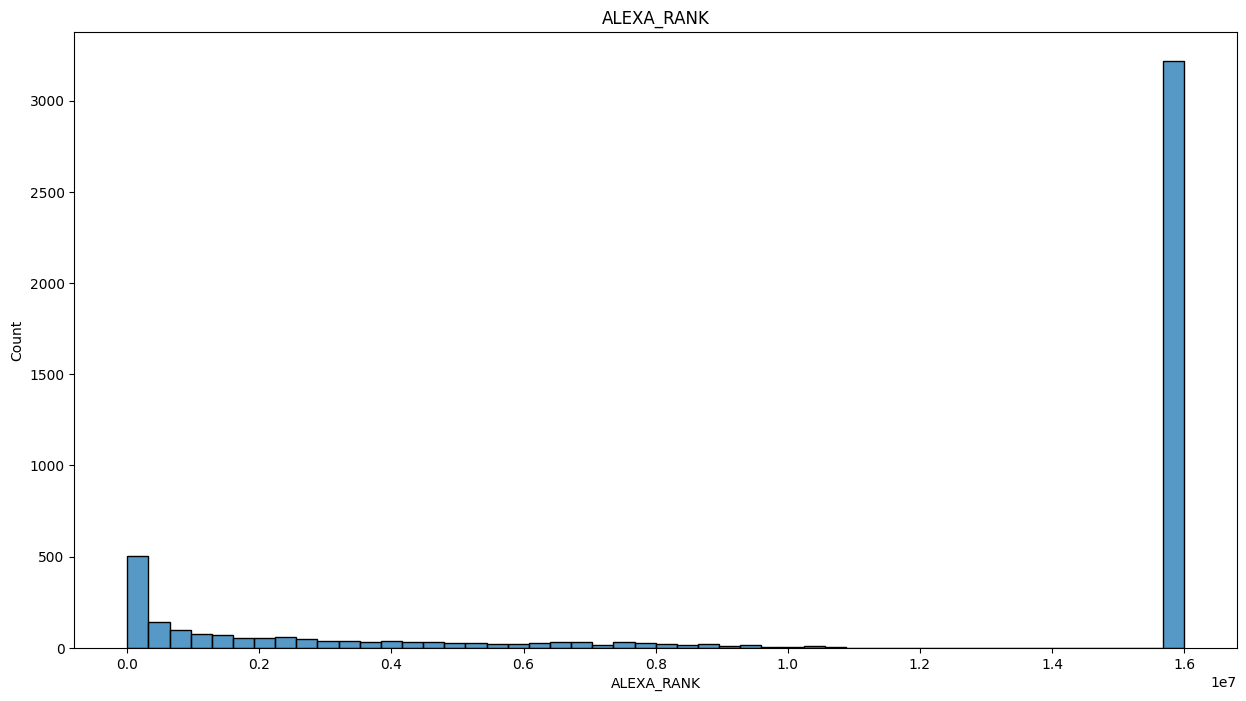

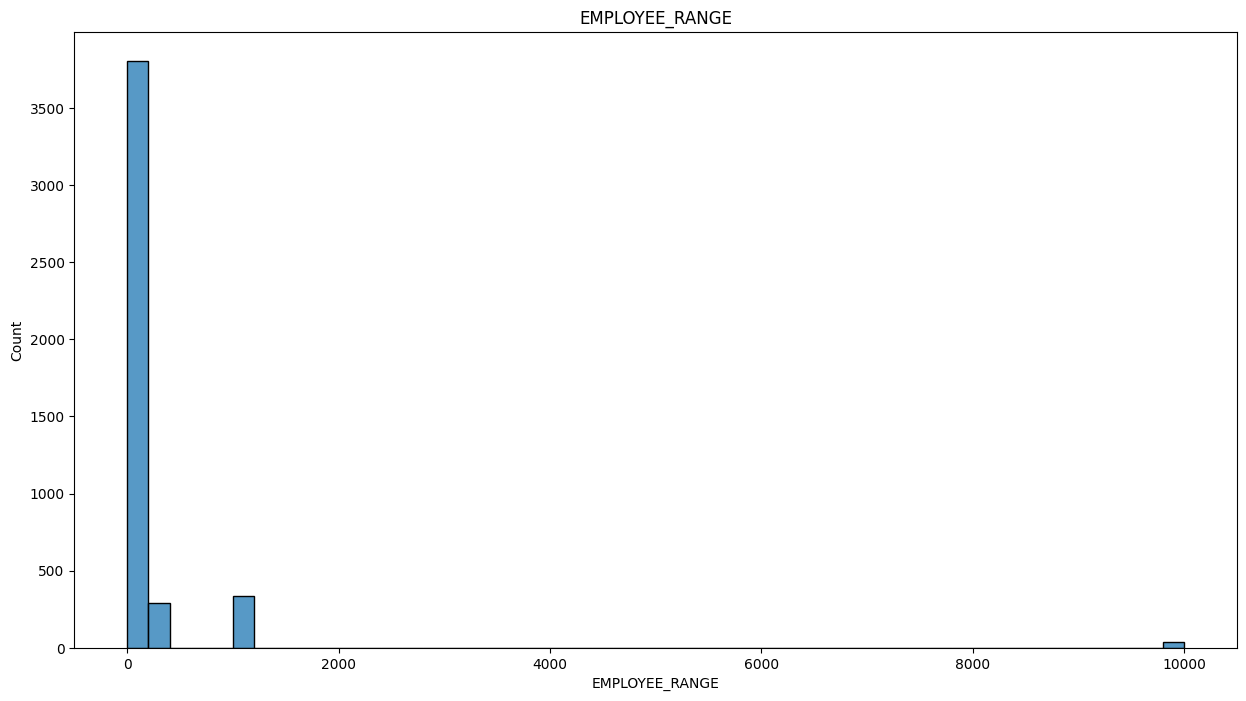

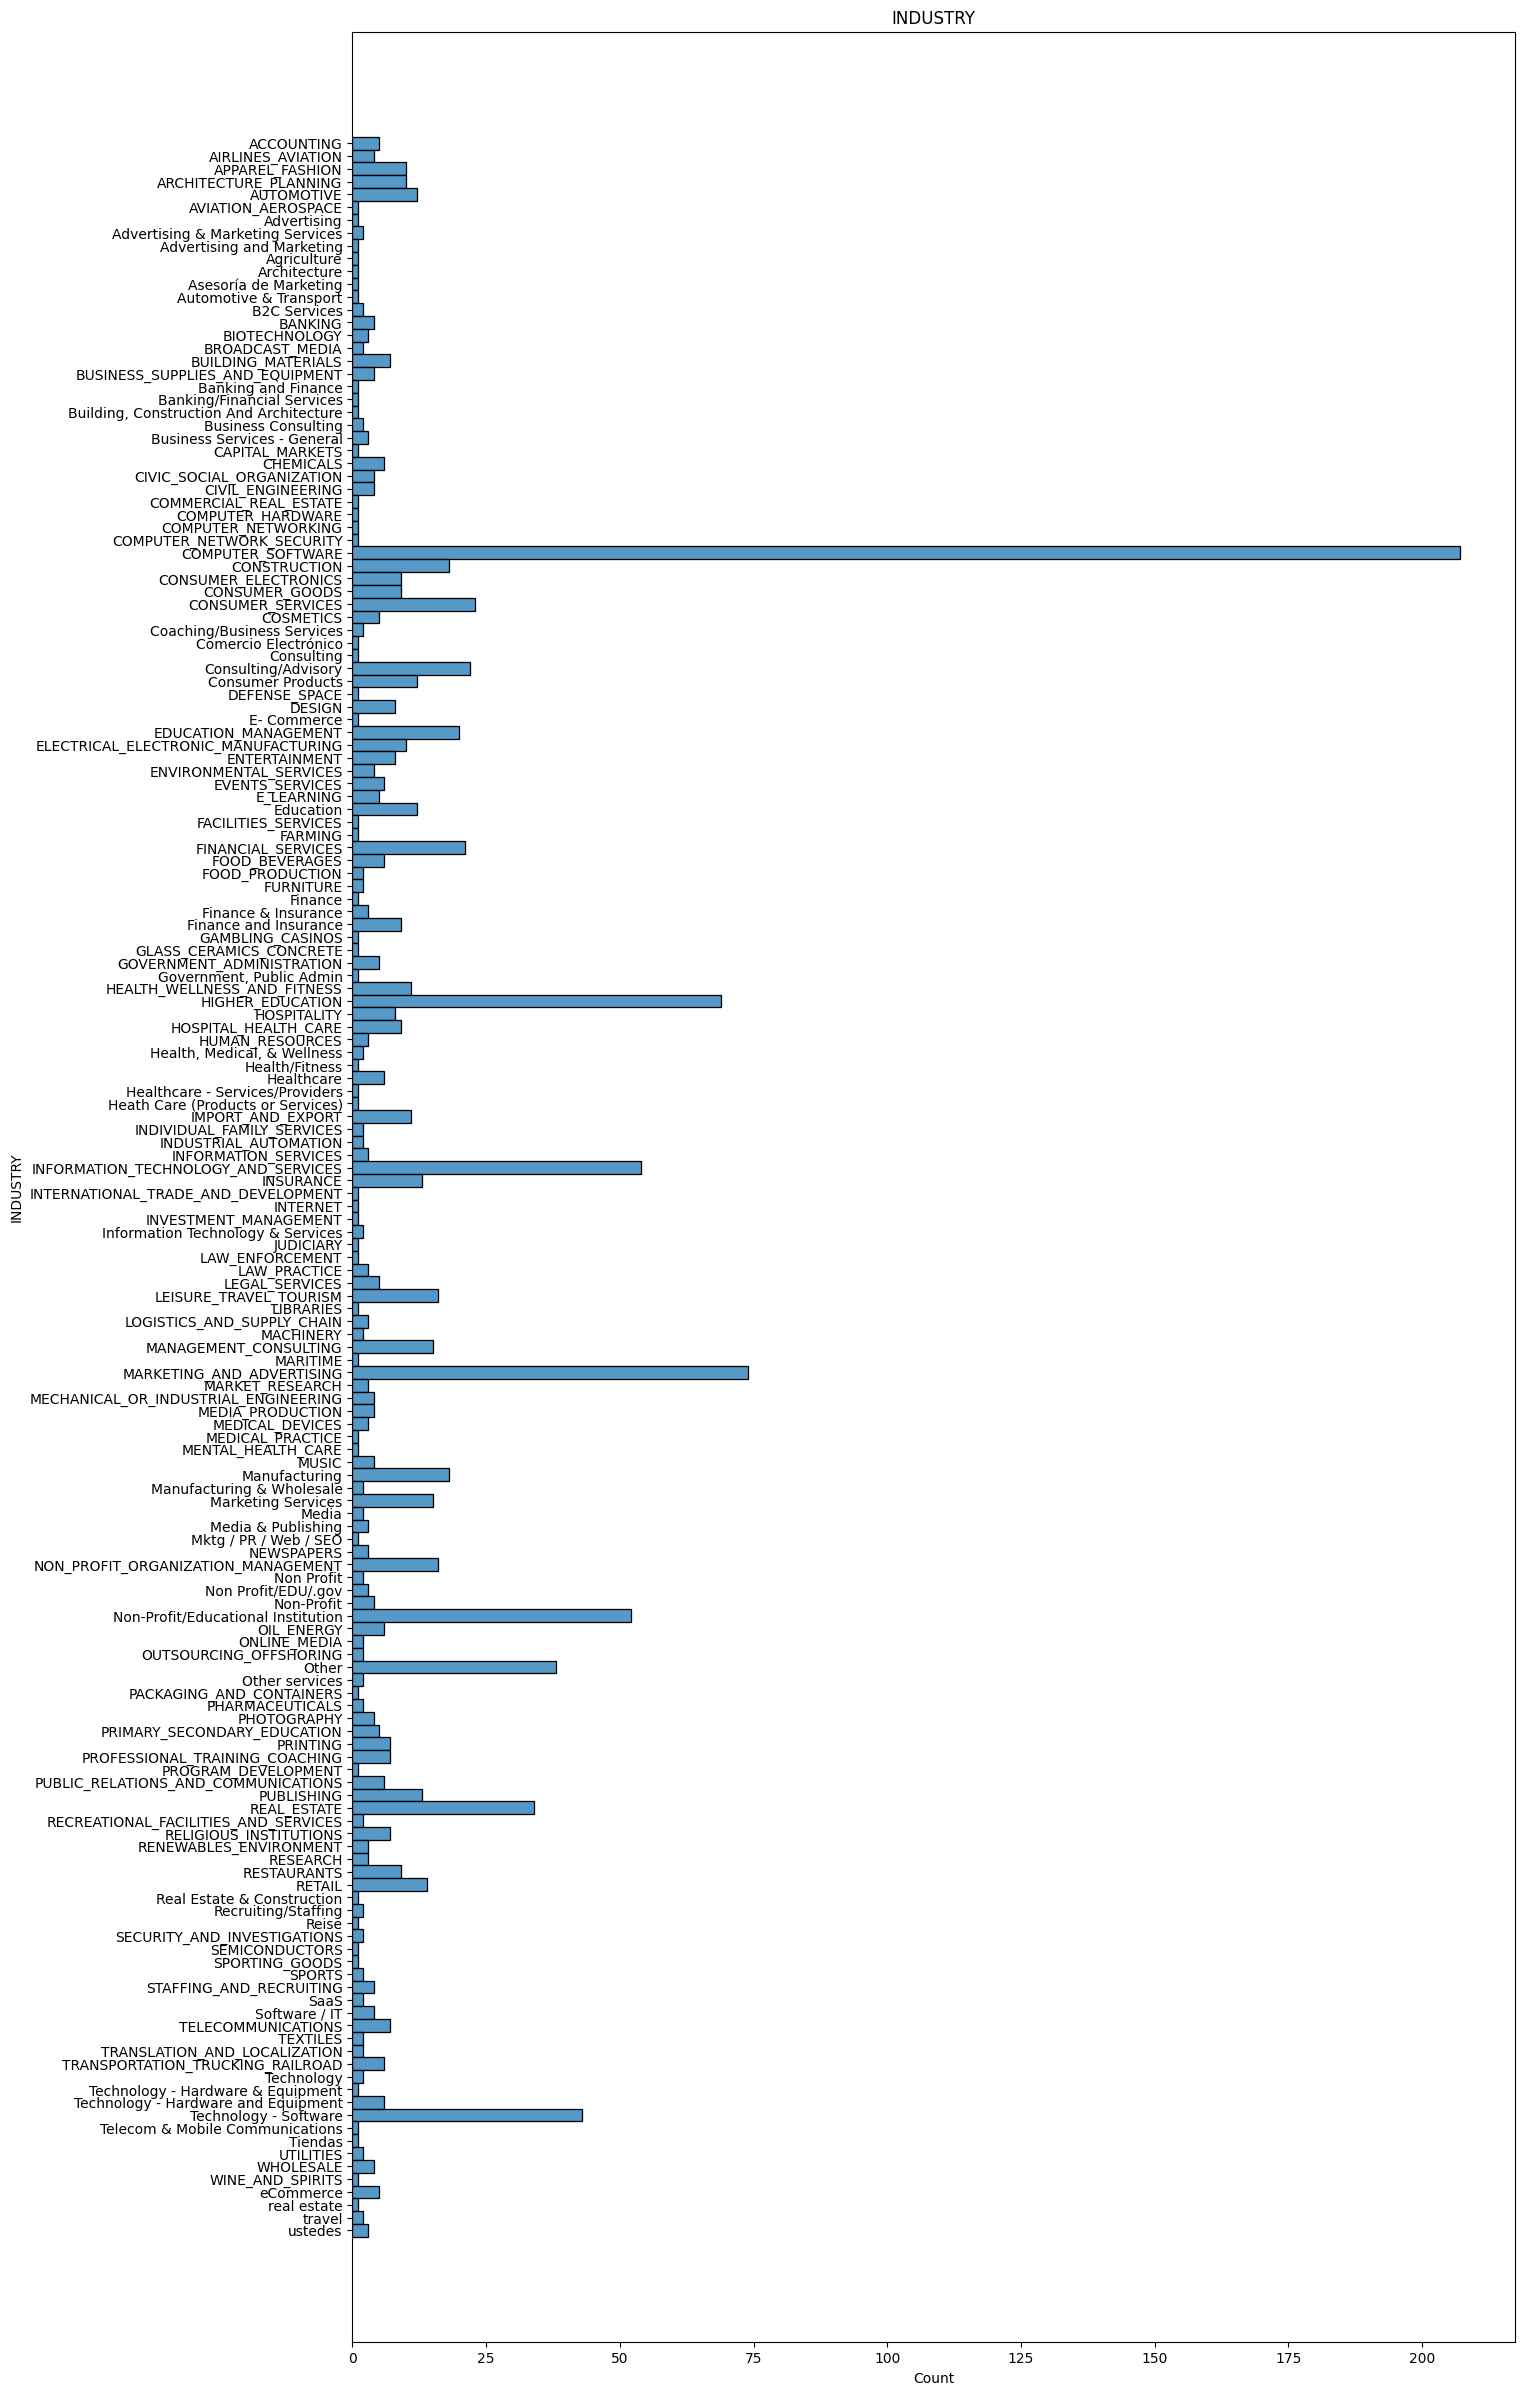

In [9]:
for c in noncustomers.columns:
    if c == 'INDUSTRY':
        plt.figure(figsize=(15,30))
        g = seaborn.histplot(y=noncustomers[c])
    else:
        plt.figure(figsize=(15,8))
        g = seaborn.histplot(x=noncustomers[c], bins=50)
    g.set_title(c)
    display(g)

In [10]:
usage_actions = pd.read_csv('usage_actions.csv')

In [11]:
usage_actions.head()

,WHEN_TIMESTAMP,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,id
0,2020-06-01 00:00:00.000,278,0,34,0,2,0,2,0,616
1,2020-04-20 00:00:00.000,0,0,0,0,0,0,0,0,3059
2,2019-04-29 00:00:00.000,210,1,17,11,3,1,4,1,2813
3,2020-02-24 00:00:00.000,1,1,1,0,1,1,1,0,5076
4,2020-02-17 00:00:00.000,9,9,7,0,1,1,1,0,3983


In [12]:
usage_actions = usage_actions.set_index('id')
usage_actions.WHEN_TIMESTAMP = pd.to_datetime(usage_actions.WHEN_TIMESTAMP)

<Axes: title={'center': 'WHEN_TIMESTAMP'}, xlabel='WHEN_TIMESTAMP', ylabel='Count'>

<Axes: title={'center': 'ACTIONS_CRM_CONTACTS'}, xlabel='ACTIONS_CRM_CONTACTS', ylabel='Count'>

<Axes: title={'center': 'ACTIONS_CRM_COMPANIES'}, xlabel='ACTIONS_CRM_COMPANIES', ylabel='Count'>

<Axes: title={'center': 'ACTIONS_CRM_DEALS'}, xlabel='ACTIONS_CRM_DEALS', ylabel='Count'>

<Axes: title={'center': 'ACTIONS_EMAIL'}, xlabel='ACTIONS_EMAIL', ylabel='Count'>

<Axes: title={'center': 'USERS_CRM_CONTACTS'}, xlabel='USERS_CRM_CONTACTS', ylabel='Count'>

<Axes: title={'center': 'USERS_CRM_COMPANIES'}, xlabel='USERS_CRM_COMPANIES', ylabel='Count'>

<Axes: title={'center': 'USERS_CRM_DEALS'}, xlabel='USERS_CRM_DEALS', ylabel='Count'>

<Axes: title={'center': 'USERS_EMAIL'}, xlabel='USERS_EMAIL', ylabel='Count'>

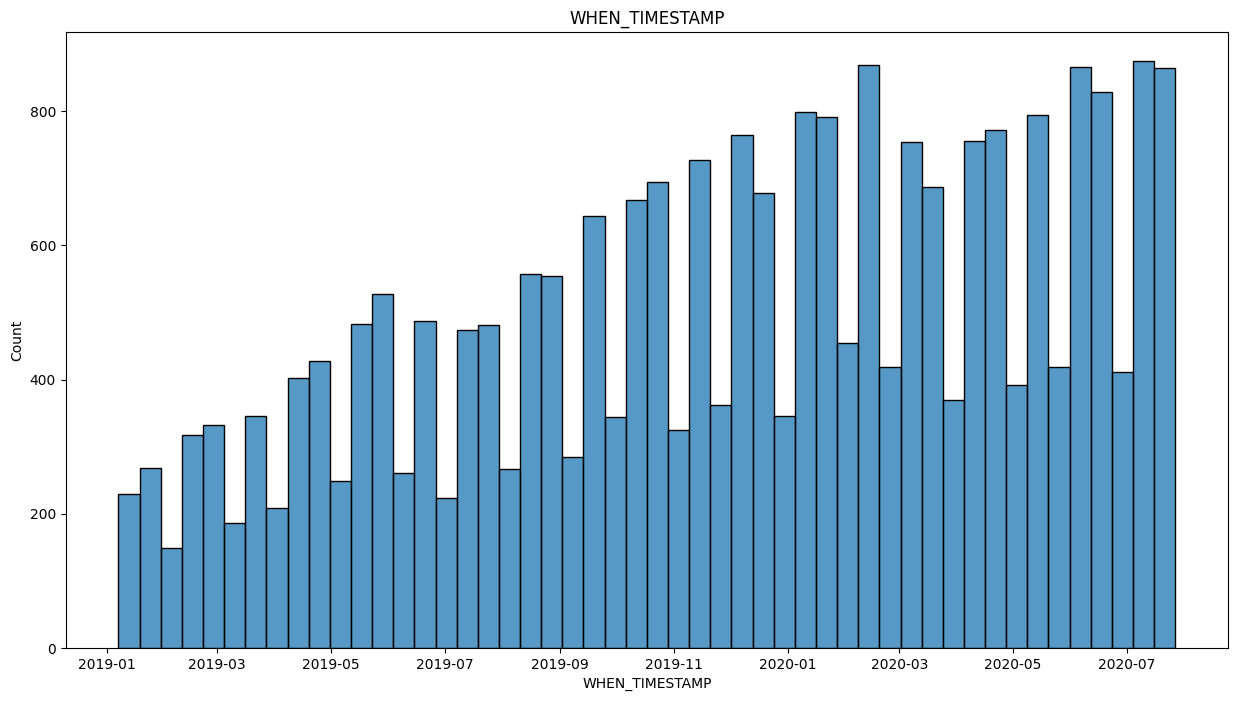

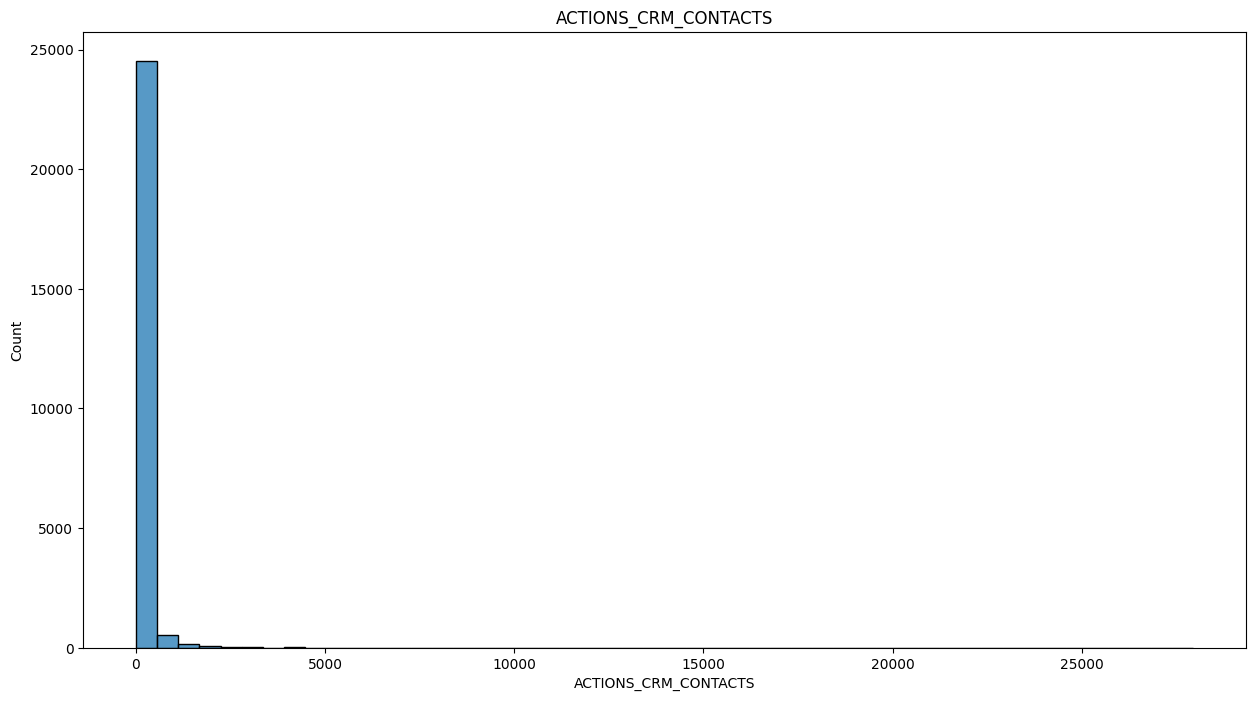

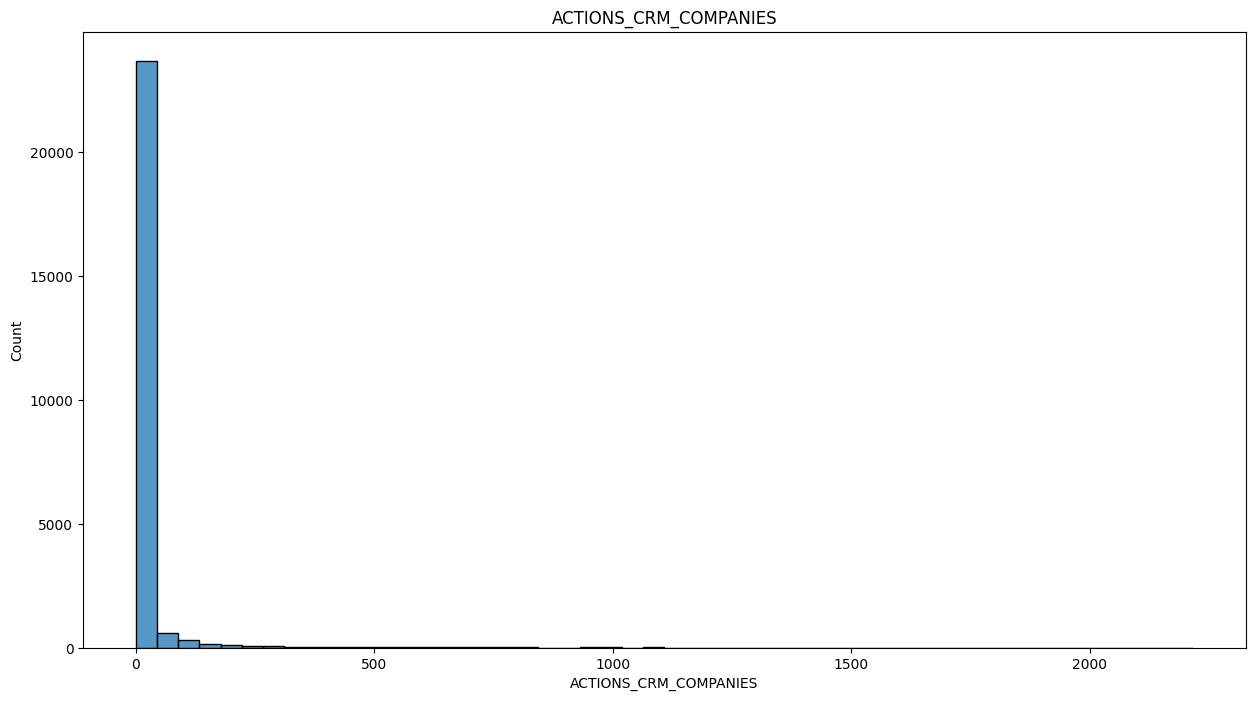

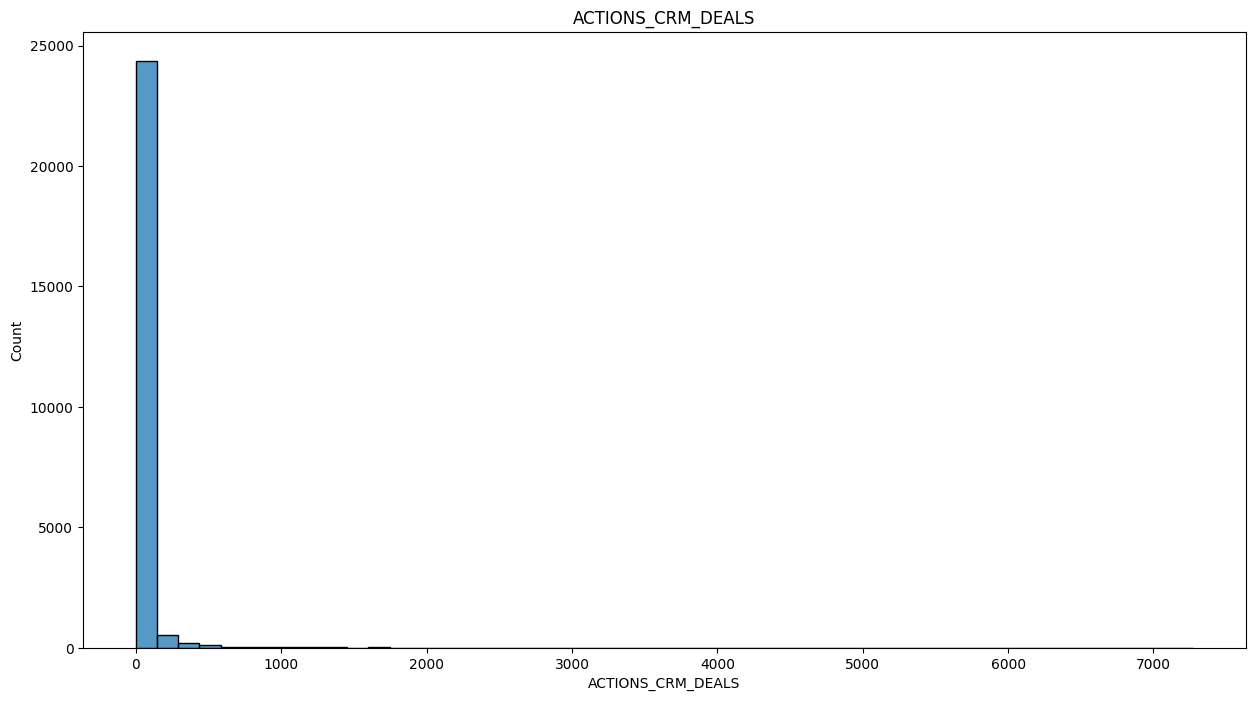

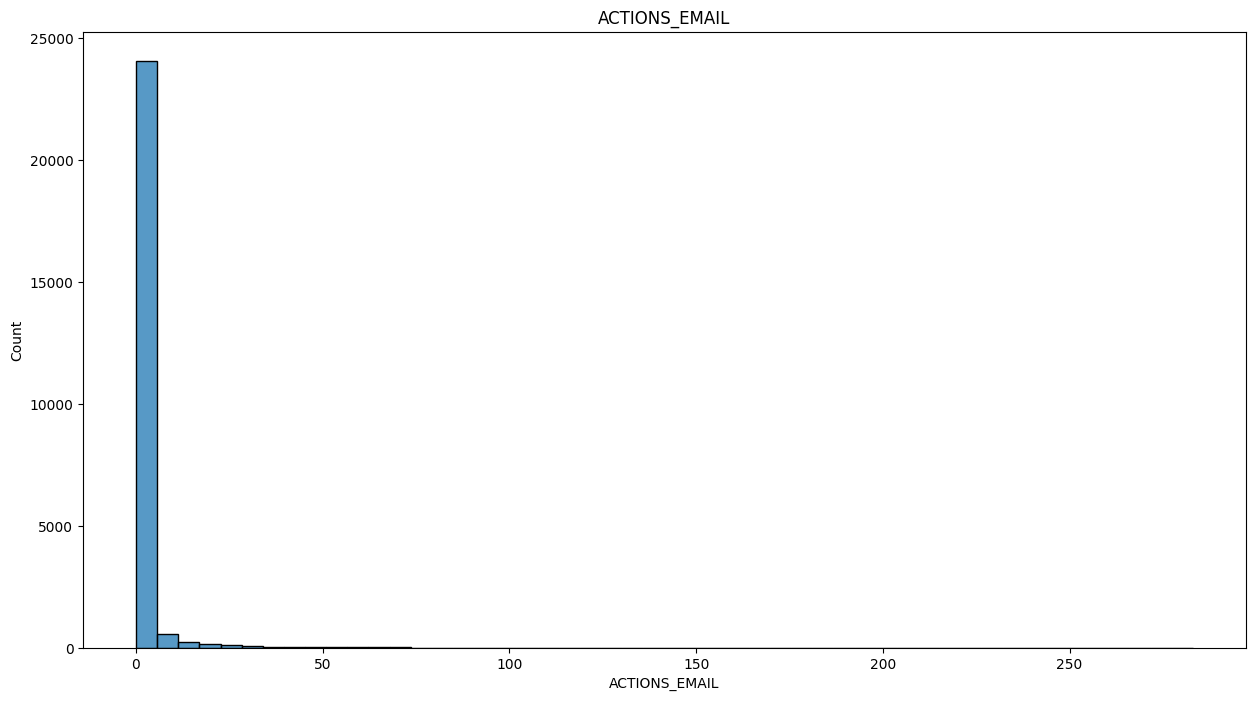

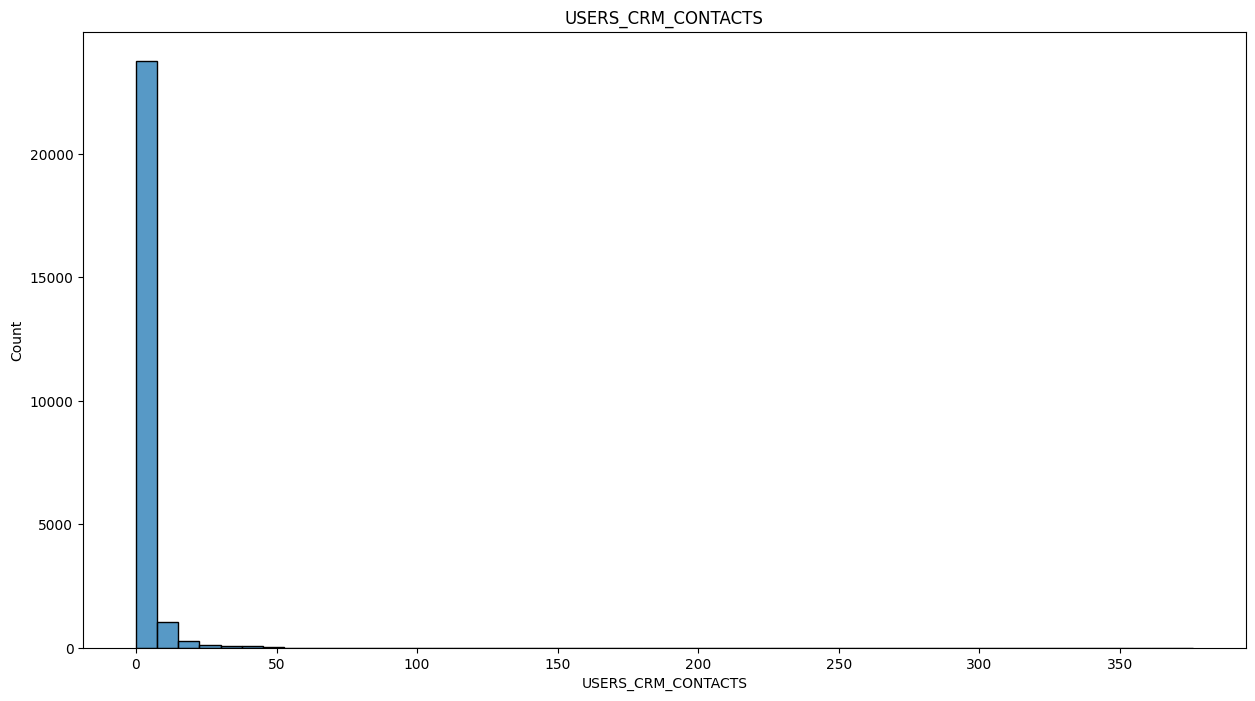

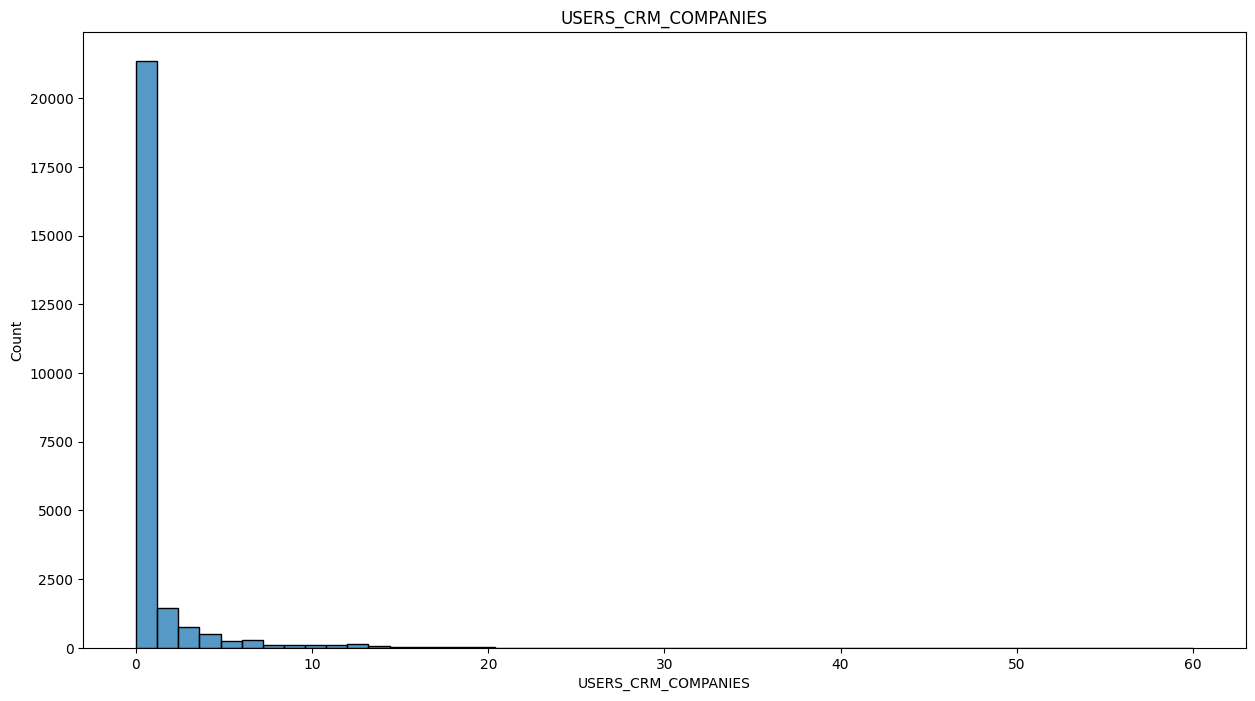

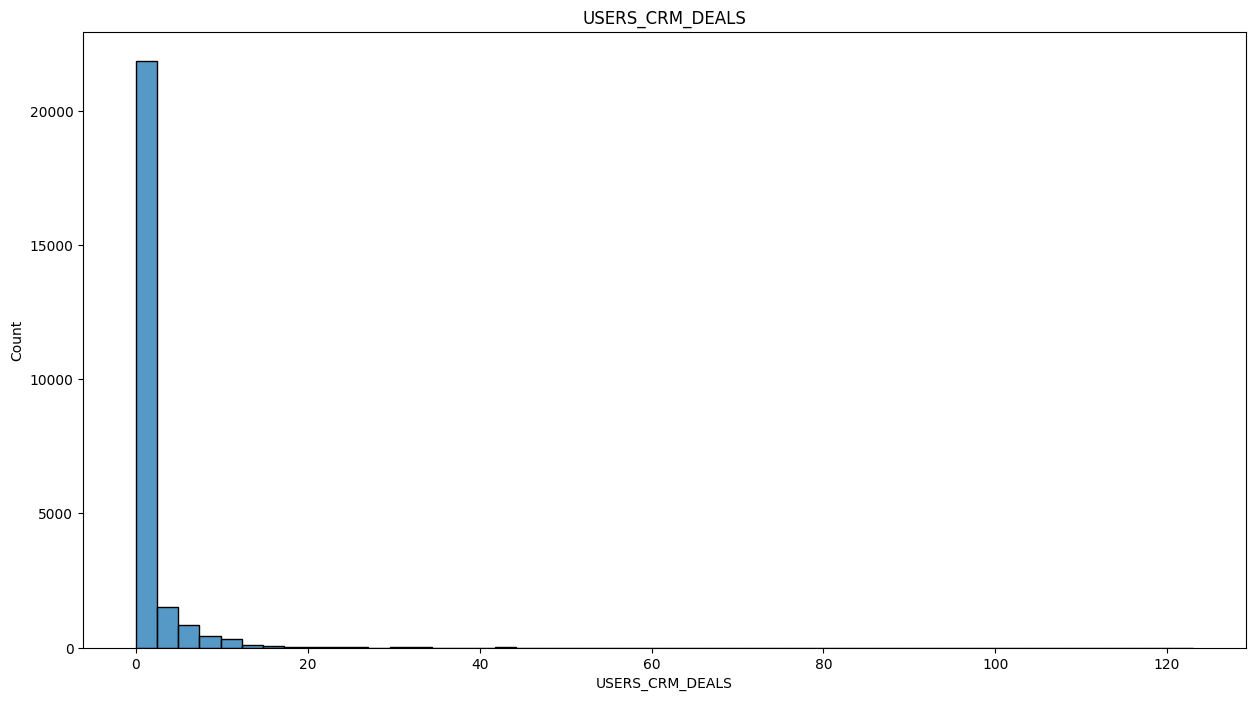

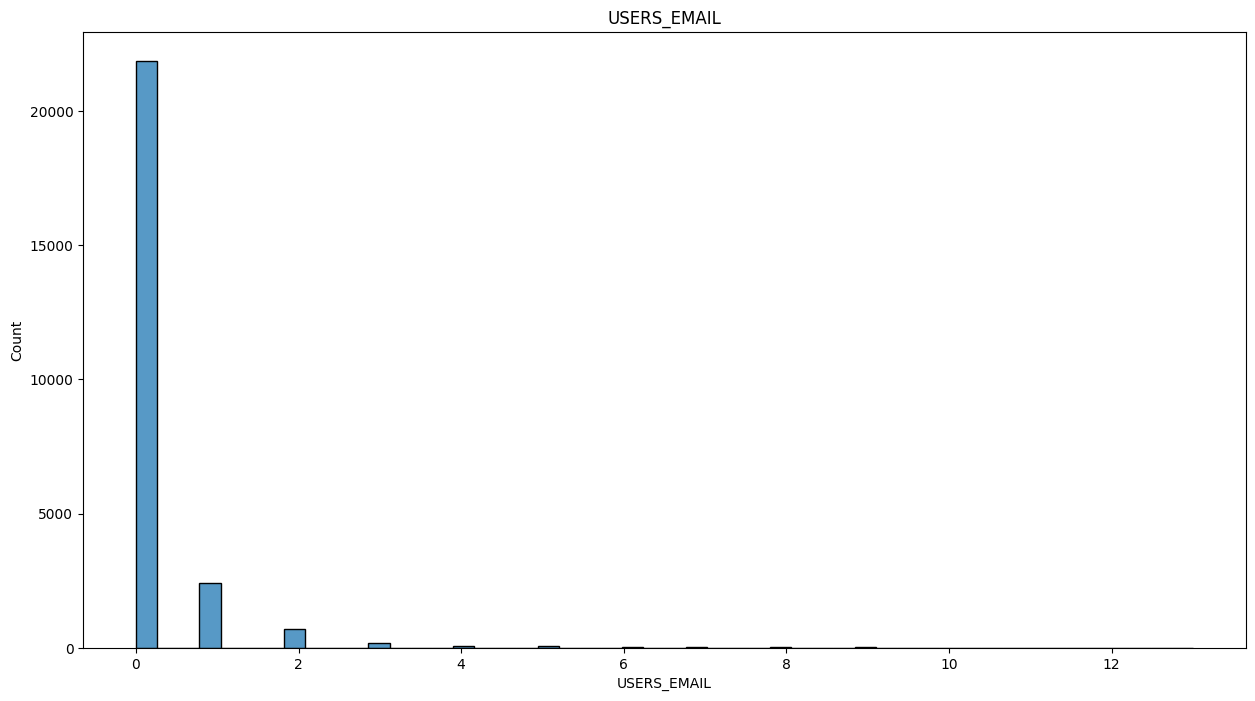

In [13]:
for c in usage_actions.columns:
    if c == 'INDUSTRY':
        plt.figure(figsize=(15,30))
        g = seaborn.histplot(y=usage_actions[c])
    elif c == 'EMPLOYEE_RANGE':
        plt.figure(figsize=(15,8))
        g = seaborn.histplot(x=usage_actions[c] + 1, log_scale=True, bins = 50)
    else:
        plt.figure(figsize=(15,8))
        g = seaborn.histplot(x=usage_actions[c], bins = 50)
    g.set_title(c)
    display(g)

## Feature Engineering

    Because we have the advantage of timestamps on the behavioral aggregates and on the target event (conversion to paying customer), we are able to leverage time-relative features. For the sake of limiting the time invested here, we will engineer the first, second and third derivative of each aggregated moment, the same relative derivatives and the rolling sum, mean, max and min for each aggregate across windows of size 4, 8 and 12 weeks.
    
    Considering that the user behavior before conversion is both most likely a more useful feature and also the information that we will have available to use in our forecasts, we also lag each of these engineered features across the two weeks before conversion.

In [14]:
def add_features(df):
    feature_dfs = {}
    feature_dfs['d/dt'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).diff()
    feature_dfs['d2/dt2'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).diff().diff()
    feature_dfs['d3/dt3'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).diff().diff().diff()
    feature_dfs['pct_d/dt'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).pct_change()
    feature_dfs['pct_d2/dt2'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).pct_change().diff()
    feature_dfs['pct_d3/dt3'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).pct_change().diff().diff()
    feature_dfs['rolling_4_sum'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(4).sum()
    feature_dfs['rolling_8_sum'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(8).sum()
    feature_dfs['rolling_12_sum'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(12).sum()
    feature_dfs['rolling_4_mean'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(4).mean()
    feature_dfs['rolling_8_mean'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(8).mean()
    feature_dfs['rolling_12_mean'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(12).mean()
    feature_dfs['rolling_4_max'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(4).max()
    feature_dfs['rolling_8_max'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(8).max()
    feature_dfs['rolling_12_max'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(12).max()
    feature_dfs['rolling_4_min'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(4).min()
    feature_dfs['rolling_8_min'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(8).min()
    feature_dfs['rolling_12_min'] = df.drop(
        columns=['WHEN_TIMESTAMP']
    ).rolling(12).min()
    for _df in feature_dfs:
        feature_dfs[_df].columns = [
            '{}_{}'.format(_df, c) for c in feature_dfs[_df].columns
        ]
    new_df = pd.concat([df] + [
        feature_dfs[_df] for _df in feature_dfs
    ], axis=1)
    return new_df
    

In [15]:
%%capture
usage_actions = usage_actions.groupby('id').apply(add_features)

In [17]:
def long_to_wide(df):
    df = df.sort_values('WHEN_TIMESTAMP').set_index('WHEN_TIMESTAMP')/
    .resample('W-MON').sum()
    df_long = pd.DataFrame(index=df.index)
    for lag in range(1, 2):
        for c in [c for c in df.columns if c != 'WHEN_TIMESTAMP']:
            df_long['{}_lag_{}'.format(c, lag)] = df[c].shift(lag)
    return pd.concat([df, df_long], axis=1)

In [18]:
%%capture
usage_actions_wide = usage_actions.groupby('id').apply(long_to_wide)

In [19]:
noncustomers['CLOSEDATE'] = datetime.datetime(year=2523, month=1, day=1)
noncustomers['MRR'] = 0
noncustomers = noncustomers[[c for c in customers.columns]]
clients = pd.concat([customers, noncustomers])

In [20]:
master = usage_actions_wide.merge(clients, left_index=True, right_index=True)

## Q&A - Descriptive Analytics
Q: Of prospects that do become customers, how is usage related to their spend? No need
to build a model; we’re looking for a summary of insights.

A: From a correlation perspective, the charts below show us that the most active users are consistently NOT the most revenue-generating. They are, however, more consistly highly ranked by the Alexa module.

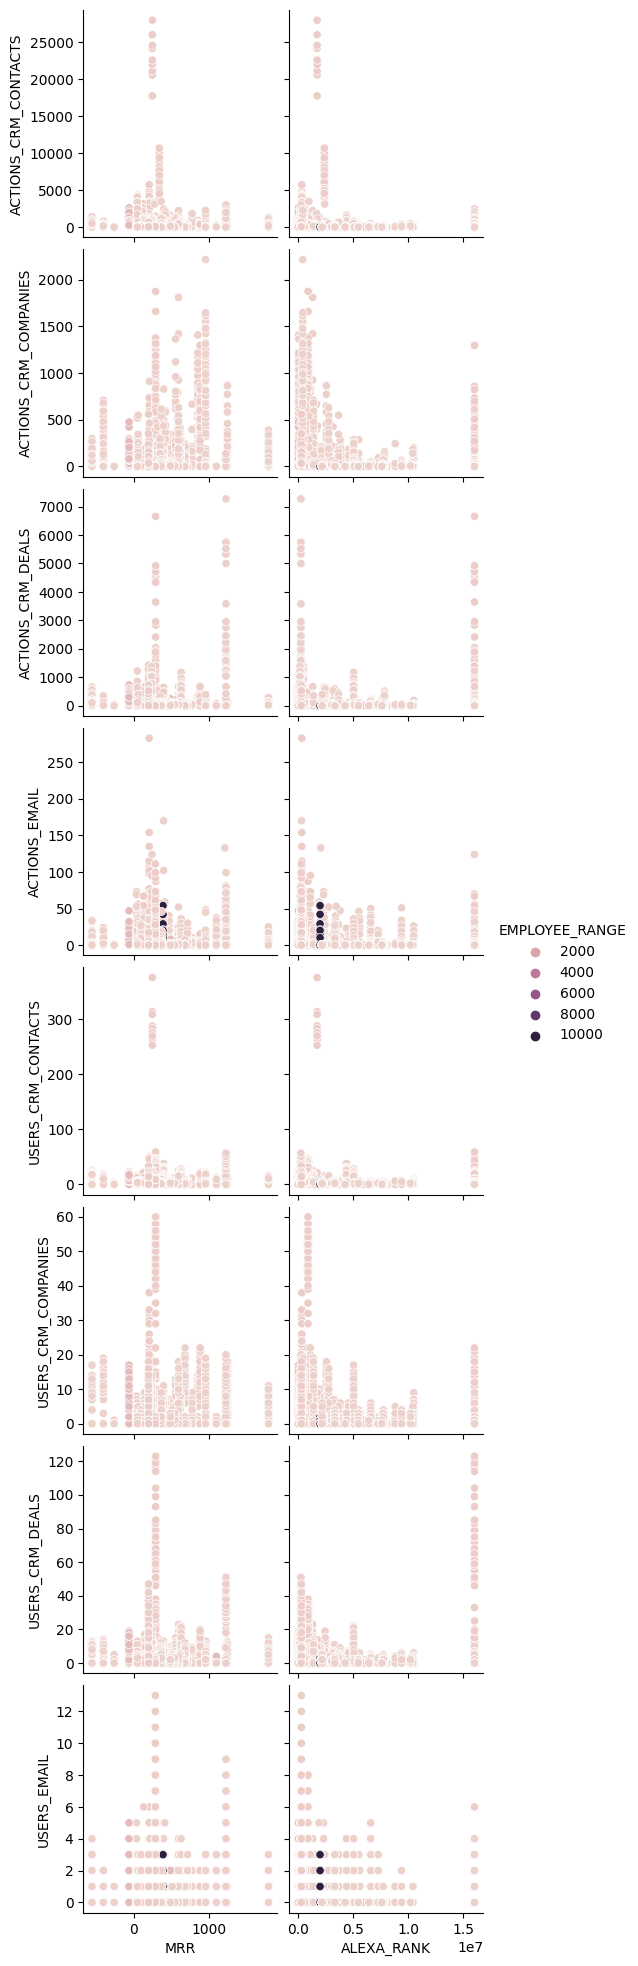

In [21]:
import matplotlib.pyplot as plt
seaborn.pairplot(
    master[~(master['CLOSEDATE'] == datetime.datetime(year=2523, month=1, day=1))],
    x_vars=['MRR', 'ALEXA_RANK'],
    y_vars=['ACTIONS_CRM_CONTACTS', 'ACTIONS_CRM_COMPANIES','ACTIONS_CRM_DEALS',/
            'ACTIONS_EMAIL','USERS_CRM_CONTACTS','USERS_CRM_COMPANIES','USERS_CRM_DEALS',/
            'USERS_EMAIL'],
    hue='EMPLOYEE_RANGE'
)

## Target Definition

    We define the target as the probability (bisected into True and False predictions) that the customer will convert next week, given their demographics, behavioral data from the preceding weeks and seasonal time-based factors.
    
    We also filter out of our training and validation datasets observations that correspond to weeks after a client has converted, as that is by definition outside of the feature space the model will be used on in production.

In [22]:
def construct_target(df):
    df['converts_next_week'] = df['CLOSEDATE'].between(df['WHEN_TIMESTAMP'], /
                                                       df['WHEN_TIMESTAMP'].shift(-1), /
                                                       inclusive='right')
    return df

In [23]:
%%capture
master = master.reset_index().groupby('id').apply(construct_target)

In [24]:
master['converted'] = master['CLOSEDATE'] < master['WHEN_TIMESTAMP']

In [25]:
filtered_master = master[
                    (master['converts_next_week']) | (~master['converted'])
                    ].drop(columns=['converted', 'CLOSEDATE'])

In [26]:
for c in filtered_master.columns:
    if filtered_master[c].dtype == 'object':
        filtered_master[c] = filtered_master[c].fillna('NAN')
        filtered_master[c] = filtered_master[c].astype('category')
    elif c in filtered_master.select_dtypes(include=['int64','float64']):
        filtered_master[c] = filtered_master[c].fillna(-999999)

In [37]:
%%capture
filtered_master['WHEN_TIMESTAMP'] =  pd.to_datetime(
    filtered_master['WHEN_TIMESTAMP']
)
filtered_master['week_of_year'] = filtered_master['WHEN_TIMESTAMP'].dt.week
filtered_master["week_of_month"] = filtered_master['WHEN_TIMESTAMP'].dt.day // 7 + 1

SyntaxError: invalid syntax (53023052.py, line 5)

In [38]:
split = int(len(filtered_master) * .8)
filtered_master = filtered_master.sort_values('WHEN_TIMESTAMP')
X_train = filtered_master[
    [c for c in filtered_master if not c in [
        'converts_next_week', 'WHEN_TIMESTAMP', 'id', 'MRR'
        ]
    ]
][:split]
y_train = filtered_master['converts_next_week'][:split]
X_test = filtered_master[
    [c for c in filtered_master if not c in [
        'converts_next_week', 'WHEN_TIMESTAMP', 'id', 'MRR'
        ]
    ]
][split:]
y_test = filtered_master['converts_next_week'][split:]

In [35]:
model = CatBoostClassifier()
model.fit(X_train,
          y_train, cat_features=[
              c for c in X_train.columns if 
                                 X_train[c].dtype == 'category'
          ], verbose=False)

SyntaxError: invalid syntax (2894971176.py, line 3)

In [30]:
model.set_probability_threshold(0.00045)
y_pred = model.predict(X_test)

## Q&A - Validation

A: Can you effectively predict who is likely to convert from a prospect and become a
customer?

Q: The model, with an adjusted likelihood threshold, has very high recall, but low precision. That means that it will, most likely, be able to accurately identify ~30% of potential customers as accounts that will not convert next week. This would be useful in allocating marketing budgets and prioritizing customer support resources.

It will not, however, be able to reliably tell you which accounts will indeed convert next week.

In [31]:
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,False,True,All
Actual,,,
False,3375,5692,9067
True,1,42,43
All,3376,5734,9110


In [32]:
shap.initjs()

In [33]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

## Q&A - Interpretation

Q: Of all the prospects that we have, some become customers. What are the biggest
differentiators between prospects that become customers and prospects that do not
become customers?

A: Although the Alexa rank is a meta-attribute of the customer, it does seem to have significant predictive value in terms of conversion. The number of employees is also a large factor, followed by seasonal effects and then rolling behavioral minimums other statistical moments, then the absolute and relative rates of change in behavior.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


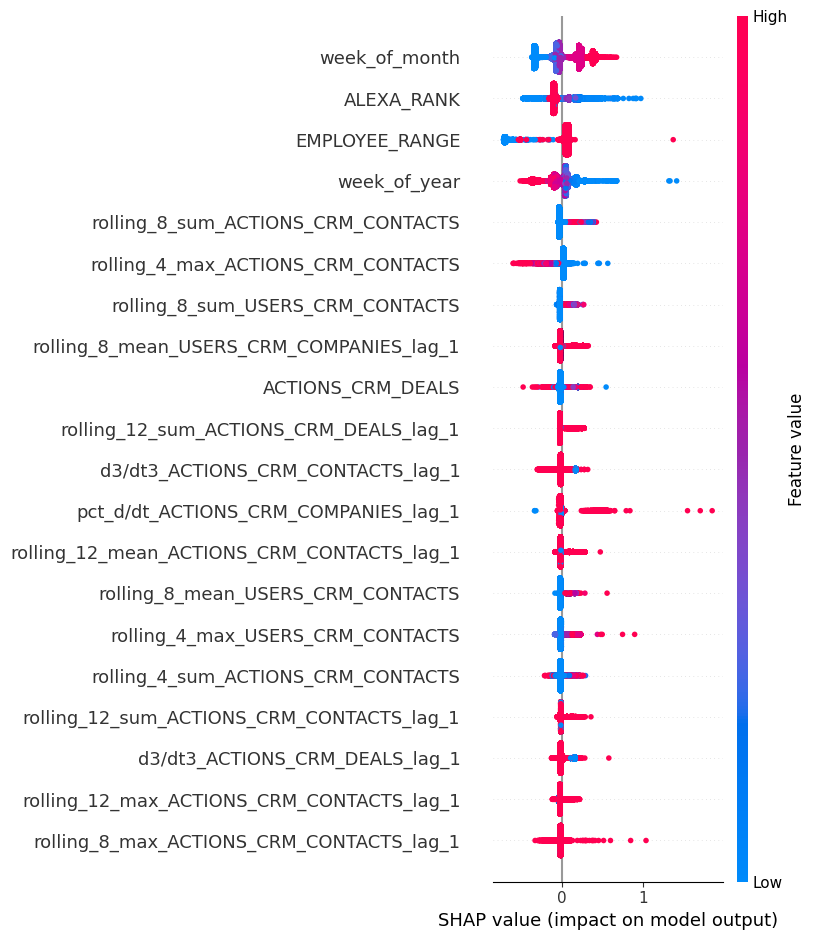

In [34]:
shap.summary_plot(shap_values, X_train)

## Q&A - Next Steps

Q: Where would you next invest if this was a funded project?

A: If this were a paid project with sufficient time and resources available, one of the first, next areas of investment would be to benchmark a logistic regression model. The majority of the behavioral usage features are gamma distributed, meaning that they could easily be exponentiated to meet the assumptions of a linear model, and the continuous nature of the usage metrics makes a linear model better suited to generalizing un-seen pieces of the feature space (it will perform better as bigger, more active customers are won). If a linear model were to perform as well as or better than the tree model, it would be more efficient computationally to deploy and maintain. We would also invest in more thorough feature engineering, hyperparameter-optimization and benchmarking a novel boosting technique of my own. If this were being used to forecast internal revenue, we would invest in building a set of macro-economic features.

## Contact
If you have any questions on this analysis, or are interested in further investing in the project, please reach out to john@coysu.com.